# 2D Acoustic Wave
---
- Model Setup: [this link](https://github.com/devitocodes/devito/blob/master/examples/seismic/tutorials/01_modelling.ipynb)

- target: $c(x, z)^2$.

- rescaling: $x' = x/1000, z' = z/1000, t' = t/1000$.

---

# Direct Problem only,  without Source;

# Full Snapshots

# Exact velocity field

# target: learn the forward model and try to reduce residue error

In [1]:
NAME = "0727_full_snapshots_and_velocity_combination"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [3]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0, w1):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-2], layers[2:-1], keys[1:-2])] + \
			[siren_layer_params(keys[-1], w1*jnp.sqrt(c0/layers[-2]), layers[-2], layers[-1])]

layers = [3, 32, 32, 32, 32, 32, 32, 32, 32, 1] # (x, z, t) -> p
c0 = 1.0
w0 = 10.0
w1 = 10.0
lambda_0 = 1e-10
# direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0, w1)

direct_NAME = "0727_full_snapshots_and_velocity_dirichlet"
direct_iteration = 100000
direct_params = np.load("models/{}/iteration_{}/params.npy".format(direct_NAME, direct_iteration), allow_pickle=True)
direct_params = [[jnp.asarray(arr) for arr in Arr] for Arr in direct_params]

@jax.jit
def scalar_direct_model(params, x, z, t):
	x_ = jnp.hstack([x, z, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])


from jax import lax

@jax.jit
def scalar_inverse_model(x, z): # scaled to [-1, 1]
	return lax.cond(z[0] >= 0.0, z, lambda z: z*0+2.5, z, lambda z: z*0+1.5)

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))
inverse_model = jax.jit(jax.vmap(scalar_inverse_model, in_axes = (0, 0)))

In [4]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def scalar_dp_dx(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, z, t))

@jax.jit
def scalar_dp_dz(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, z, t))

@jax.jit
def scalar_dp_dt(params, x, z, t):
    return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, z, t))

@jax.jit
def dp_dxx(params, x, z, t):
    return jax.grad(scalar_dp_dx, 1)(params, x, z, t)

@jax.jit
def dp_dzz(params, x, z, t):
    return jax.grad(scalar_dp_dz, 2)(params, x, z, t)

@jax.jit
def dp_dtt(params, x, z, t):
    return jax.grad(scalar_dp_dt, 3)(params, x, z, t)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
    
	c = inverse_model(collocation.x, collocation.z)
	dp_dtt_ = dp_dtt(direct_params, collocation.x, collocation.z, collocation.t)
	dp_dxx_ = dp_dxx(direct_params, collocation.x, collocation.z, collocation.t)
	dp_dzz_ = dp_dzz(direct_params, collocation.x, collocation.z, collocation.t)
	p_pred = direct_model(direct_params, dirichlet.x, dirichlet.z, dirichlet.t).reshape((-1, 1))
	
	loss_c = mse(dp_dtt_ - c**2*(dp_dxx_ + dp_dzz_), 0)
	loss_d = mse(p_pred, dirichlet.p)
	return loss_c, loss_d

@jax.jit
def loss_fn(params, batch):
	
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["Weights"]["c"]*loss_c + batch["Weights"]["d"]*loss_d + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["Weights"]["c"]*loss_c + batch["Weights"]["d"]*loss_d, loss_c, loss_d


In [5]:
import pickle 
with open("dataset_single_source.pkl", "rb") as file:
	x, z, t, p = pickle.load(file)
	
tzx = tensor_grid([t, z, x])
x, z, t = tzx[:, 2:3], tzx[:, 1:2], tzx[:, 0:1]
p = p.reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "z", "t", "p"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [x, z, t, p]))


class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [6]:
lr = 1e-4
start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1e-8
w_d = 100.0

key = random.PRNGKey(1)
Dirichlet = Batch_Generator(key, dirichlet, batch_size_dirichlet)
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 08:34:20, Iteration: 500, Train Loss: 4.6428e-01, c: 1.4691e+06, d: 4.4958e-03
2020/07/31, 08:34:25, Iteration: 1000, Train Loss: 4.5151e-01, c: 1.3857e+06, d: 4.3765e-03
2020/07/31, 08:34:29, Iteration: 1500, Train Loss: 4.6237e-01, c: 1.5098e+06, d: 4.4728e-03
2020/07/31, 08:34:34, Iteration: 2000, Train Loss: 4.4102e-01, c: 1.0849e+06, d: 4.3017e-03
2020/07/31, 08:34:38, Iteration: 2500, Train Loss: 4.3945e-01, c: 8.4600e+05, d: 4.3099e-03
2020/07/31, 08:34:43, Iteration: 3000, Train Loss: 4.4540e-01, c: 8.4341e+05, d: 4.3697e-03
2020/07/31, 08:34:47, Iteration: 3500, Train Loss: 4.3889e-01, c: 7.2948e+05, d: 4.3159e-03
2020/07/31, 08:34:51, Iteration: 4000, Train Loss: 4.5189e-01, c: 1.0522e+06, d: 4.4137e-03
2020/07/31, 08:34:56, Iteration: 4500, Train Loss: 4.5165e-01, c: 6.6059e+05, d: 4.4504e-03
2020/07/31, 08:35:00, Iteration: 5000, Train Loss: 4.5098e-01, c: 6.4960e+05, d: 4.4449e-03
2020/07/31, 08:35:05, Iteration: 5500, Train Loss: 4.3538e-01, c: 9.4567e+05, d: 

2020/07/31, 08:40:57, Iteration: 45000, Train Loss: 4.0541e-01, c: 6.4346e+05, d: 3.9897e-03
2020/07/31, 08:41:02, Iteration: 45500, Train Loss: 4.0413e-01, c: 4.7517e+05, d: 3.9937e-03
2020/07/31, 08:41:06, Iteration: 46000, Train Loss: 3.8657e-01, c: 4.7165e+05, d: 3.8185e-03
2020/07/31, 08:41:11, Iteration: 46500, Train Loss: 3.8359e-01, c: 5.6668e+05, d: 3.7793e-03
2020/07/31, 08:41:15, Iteration: 47000, Train Loss: 3.8869e-01, c: 5.7979e+05, d: 3.8290e-03
2020/07/31, 08:41:19, Iteration: 47500, Train Loss: 3.9485e-01, c: 5.4820e+05, d: 3.8937e-03
2020/07/31, 08:41:24, Iteration: 48000, Train Loss: 3.8390e-01, c: 4.3268e+05, d: 3.7958e-03
2020/07/31, 08:41:28, Iteration: 48500, Train Loss: 3.9220e-01, c: 4.2015e+05, d: 3.8800e-03
2020/07/31, 08:41:33, Iteration: 49000, Train Loss: 3.7334e-01, c: 4.6107e+05, d: 3.6873e-03
2020/07/31, 08:41:37, Iteration: 49500, Train Loss: 3.8186e-01, c: 5.2255e+05, d: 3.7664e-03
2020/07/31, 08:41:42, Iteration: 50000, Train Loss: 3.9413e-01, c: 6.1

2020/07/31, 08:47:33, Iteration: 89500, Train Loss: 3.4568e-01, c: 3.0562e+05, d: 3.4263e-03
2020/07/31, 08:47:37, Iteration: 90000, Train Loss: 3.6287e-01, c: 4.2799e+05, d: 3.5859e-03
2020/07/31, 08:47:42, Iteration: 90500, Train Loss: 3.6988e-01, c: 4.7292e+05, d: 3.6515e-03
2020/07/31, 08:47:46, Iteration: 91000, Train Loss: 3.5371e-01, c: 3.9553e+05, d: 3.4975e-03
2020/07/31, 08:47:51, Iteration: 91500, Train Loss: 3.5035e-01, c: 3.8256e+05, d: 3.4653e-03
2020/07/31, 08:47:55, Iteration: 92000, Train Loss: 3.4400e-01, c: 3.9079e+05, d: 3.4009e-03
2020/07/31, 08:47:59, Iteration: 92500, Train Loss: 3.4961e-01, c: 3.4332e+05, d: 3.4618e-03
2020/07/31, 08:48:04, Iteration: 93000, Train Loss: 3.4674e-01, c: 3.6964e+05, d: 3.4304e-03
2020/07/31, 08:48:08, Iteration: 93500, Train Loss: 3.3301e-01, c: 3.5298e+05, d: 3.2948e-03
2020/07/31, 08:48:13, Iteration: 94000, Train Loss: 3.4368e-01, c: 4.4585e+05, d: 3.3922e-03
2020/07/31, 08:48:17, Iteration: 94500, Train Loss: 3.4302e-01, c: 4.2

In [9]:
start_iteration = 100000
iterations = 200000
print_every = 1000
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1e-8
w_d = 20.0

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 08:49:44, Iteration: 101000, Train Loss: 6.9759e-02, c: 3.4124e+05, d: 3.3173e-03
2020/07/31, 08:49:53, Iteration: 102000, Train Loss: 6.8790e-02, c: 3.1582e+05, d: 3.2816e-03
2020/07/31, 08:50:02, Iteration: 103000, Train Loss: 7.1788e-02, c: 3.8105e+05, d: 3.3989e-03
2020/07/31, 08:50:11, Iteration: 104000, Train Loss: 7.2304e-02, c: 3.2852e+05, d: 3.4509e-03
2020/07/31, 08:50:19, Iteration: 105000, Train Loss: 7.2142e-02, c: 2.7303e+05, d: 3.4706e-03
2020/07/31, 08:50:28, Iteration: 106000, Train Loss: 6.9533e-02, c: 3.1480e+05, d: 3.3192e-03
2020/07/31, 08:50:37, Iteration: 107000, Train Loss: 7.2341e-02, c: 2.9731e+05, d: 3.4684e-03
2020/07/31, 08:50:46, Iteration: 108000, Train Loss: 7.1527e-02, c: 3.4646e+05, d: 3.4031e-03
2020/07/31, 08:50:55, Iteration: 109000, Train Loss: 7.3271e-02, c: 3.5299e+05, d: 3.4870e-03
2020/07/31, 08:51:03, Iteration: 110000, Train Loss: 7.1870e-02, c: 2.8568e+05, d: 3.4507e-03
2020/07/31, 08:51:12, Iteration: 111000, Train Loss: 7.4942e

2020/07/31, 09:02:44, Iteration: 189000, Train Loss: 6.3160e-02, c: 2.2025e+05, d: 3.0479e-03
2020/07/31, 09:02:53, Iteration: 190000, Train Loss: 6.1804e-02, c: 2.0547e+05, d: 2.9875e-03
2020/07/31, 09:03:02, Iteration: 191000, Train Loss: 6.0698e-02, c: 2.1289e+05, d: 2.9285e-03
2020/07/31, 09:03:11, Iteration: 192000, Train Loss: 5.7824e-02, c: 1.7142e+05, d: 2.8055e-03
2020/07/31, 09:03:20, Iteration: 193000, Train Loss: 6.0121e-02, c: 2.0431e+05, d: 2.9039e-03
2020/07/31, 09:03:29, Iteration: 194000, Train Loss: 5.9794e-02, c: 1.9936e+05, d: 2.8900e-03
2020/07/31, 09:03:38, Iteration: 195000, Train Loss: 5.9824e-02, c: 1.9397e+05, d: 2.8942e-03
2020/07/31, 09:03:46, Iteration: 196000, Train Loss: 5.7820e-02, c: 2.1795e+05, d: 2.7820e-03
2020/07/31, 09:03:55, Iteration: 197000, Train Loss: 5.9007e-02, c: 1.9855e+05, d: 2.8511e-03
2020/07/31, 09:04:04, Iteration: 198000, Train Loss: 6.1698e-02, c: 2.3005e+05, d: 2.9699e-03
2020/07/31, 09:04:13, Iteration: 199000, Train Loss: 5.9999e

2020/07/31, 09:15:46, Iteration: 277000, Train Loss: 5.2147e-02, c: 1.6510e+05, d: 2.5248e-03
2020/07/31, 09:15:55, Iteration: 278000, Train Loss: 5.4340e-02, c: 1.5911e+05, d: 2.6374e-03
2020/07/31, 09:16:04, Iteration: 279000, Train Loss: 5.2657e-02, c: 1.6758e+05, d: 2.5491e-03
2020/07/31, 09:16:13, Iteration: 280000, Train Loss: 5.3682e-02, c: 1.6810e+05, d: 2.6000e-03
2020/07/31, 09:16:22, Iteration: 281000, Train Loss: 5.2554e-02, c: 1.9366e+05, d: 2.5309e-03
2020/07/31, 09:16:31, Iteration: 282000, Train Loss: 5.4430e-02, c: 1.5826e+05, d: 2.6424e-03
2020/07/31, 09:16:40, Iteration: 283000, Train Loss: 5.4359e-02, c: 1.9666e+05, d: 2.6196e-03
2020/07/31, 09:16:48, Iteration: 284000, Train Loss: 5.3084e-02, c: 1.6831e+05, d: 2.5700e-03
2020/07/31, 09:16:57, Iteration: 285000, Train Loss: 5.3249e-02, c: 1.7900e+05, d: 2.5730e-03
2020/07/31, 09:17:06, Iteration: 286000, Train Loss: 5.4111e-02, c: 2.0523e+05, d: 2.6029e-03
2020/07/31, 09:17:15, Iteration: 287000, Train Loss: 5.1795e

In [12]:
start_iteration = 300000
iterations = 300000
print_every = 1000
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1e-8
w_d = 1.0

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 11:02:43, Iteration: 301000, Train Loss: 3.9088e-03, c: 1.4730e+05, d: 2.4358e-03
2020/07/31, 11:02:52, Iteration: 302000, Train Loss: 4.0302e-03, c: 1.5384e+05, d: 2.4919e-03
2020/07/31, 11:03:00, Iteration: 303000, Train Loss: 4.0224e-03, c: 1.4578e+05, d: 2.5645e-03
2020/07/31, 11:03:09, Iteration: 304000, Train Loss: 3.7946e-03, c: 1.2877e+05, d: 2.5070e-03
2020/07/31, 11:03:18, Iteration: 305000, Train Loss: 3.9253e-03, c: 1.2601e+05, d: 2.6651e-03
2020/07/31, 11:03:27, Iteration: 306000, Train Loss: 3.7316e-03, c: 1.1492e+05, d: 2.5824e-03
2020/07/31, 11:03:36, Iteration: 307000, Train Loss: 3.8257e-03, c: 1.1568e+05, d: 2.6689e-03
2020/07/31, 11:03:44, Iteration: 308000, Train Loss: 3.6892e-03, c: 1.1262e+05, d: 2.5630e-03
2020/07/31, 11:03:53, Iteration: 309000, Train Loss: 3.8451e-03, c: 1.1370e+05, d: 2.7081e-03
2020/07/31, 11:04:02, Iteration: 310000, Train Loss: 3.7836e-03, c: 1.0918e+05, d: 2.6918e-03
2020/07/31, 11:04:11, Iteration: 311000, Train Loss: 3.9111e

2020/07/31, 11:15:45, Iteration: 389000, Train Loss: 3.1717e-03, c: 7.6419e+04, d: 2.4075e-03
2020/07/31, 11:15:54, Iteration: 390000, Train Loss: 3.0737e-03, c: 7.4333e+04, d: 2.3304e-03
2020/07/31, 11:16:03, Iteration: 391000, Train Loss: 3.3255e-03, c: 9.2799e+04, d: 2.3975e-03
2020/07/31, 11:16:12, Iteration: 392000, Train Loss: 3.3585e-03, c: 8.7469e+04, d: 2.4838e-03
2020/07/31, 11:16:21, Iteration: 393000, Train Loss: 3.1248e-03, c: 8.3168e+04, d: 2.2931e-03
2020/07/31, 11:16:30, Iteration: 394000, Train Loss: 3.0844e-03, c: 6.8674e+04, d: 2.3977e-03
2020/07/31, 11:16:39, Iteration: 395000, Train Loss: 3.1510e-03, c: 7.4794e+04, d: 2.4031e-03
2020/07/31, 11:16:48, Iteration: 396000, Train Loss: 3.3964e-03, c: 9.7850e+04, d: 2.4179e-03
2020/07/31, 11:16:57, Iteration: 397000, Train Loss: 3.1500e-03, c: 7.4836e+04, d: 2.4016e-03
2020/07/31, 11:17:05, Iteration: 398000, Train Loss: 3.4510e-03, c: 1.0501e+05, d: 2.4008e-03
2020/07/31, 11:17:14, Iteration: 399000, Train Loss: 3.1050e

2020/07/31, 11:28:48, Iteration: 477000, Train Loss: 3.2482e-03, c: 9.7062e+04, d: 2.2776e-03
2020/07/31, 11:28:57, Iteration: 478000, Train Loss: 2.8710e-03, c: 7.5544e+04, d: 2.1156e-03
2020/07/31, 11:29:06, Iteration: 479000, Train Loss: 3.0596e-03, c: 7.7537e+04, d: 2.2842e-03
2020/07/31, 11:29:15, Iteration: 480000, Train Loss: 2.8911e-03, c: 7.0183e+04, d: 2.1893e-03
2020/07/31, 11:29:24, Iteration: 481000, Train Loss: 2.7835e-03, c: 7.0471e+04, d: 2.0788e-03
2020/07/31, 11:29:33, Iteration: 482000, Train Loss: 2.9136e-03, c: 7.2072e+04, d: 2.1929e-03
2020/07/31, 11:29:42, Iteration: 483000, Train Loss: 2.7050e-03, c: 6.3120e+04, d: 2.0738e-03
2020/07/31, 11:29:51, Iteration: 484000, Train Loss: 2.7615e-03, c: 6.4197e+04, d: 2.1195e-03
2020/07/31, 11:30:00, Iteration: 485000, Train Loss: 2.7814e-03, c: 5.9628e+04, d: 2.1851e-03
2020/07/31, 11:30:09, Iteration: 486000, Train Loss: 2.8246e-03, c: 6.6001e+04, d: 2.1645e-03
2020/07/31, 11:30:18, Iteration: 487000, Train Loss: 2.7793e

2020/07/31, 11:41:53, Iteration: 565000, Train Loss: 2.9091e-03, c: 8.0705e+04, d: 2.1020e-03
2020/07/31, 11:42:01, Iteration: 566000, Train Loss: 2.8802e-03, c: 7.8371e+04, d: 2.0965e-03
2020/07/31, 11:42:10, Iteration: 567000, Train Loss: 2.6914e-03, c: 7.1552e+04, d: 1.9758e-03
2020/07/31, 11:42:19, Iteration: 568000, Train Loss: 2.5633e-03, c: 5.6795e+04, d: 1.9953e-03
2020/07/31, 11:42:28, Iteration: 569000, Train Loss: 2.7879e-03, c: 7.5197e+04, d: 2.0359e-03
2020/07/31, 11:42:37, Iteration: 570000, Train Loss: 2.5205e-03, c: 5.4285e+04, d: 1.9777e-03
2020/07/31, 11:42:46, Iteration: 571000, Train Loss: 2.7587e-03, c: 7.7493e+04, d: 1.9837e-03
2020/07/31, 11:42:55, Iteration: 572000, Train Loss: 2.7757e-03, c: 7.9911e+04, d: 1.9765e-03
2020/07/31, 11:43:04, Iteration: 573000, Train Loss: 2.6350e-03, c: 6.4708e+04, d: 1.9879e-03
2020/07/31, 11:43:13, Iteration: 574000, Train Loss: 2.5581e-03, c: 5.8601e+04, d: 1.9721e-03
2020/07/31, 11:43:21, Iteration: 575000, Train Loss: 2.7677e

In [13]:
start_iteration = 600000
iterations = 500000
print_every = 1000
save_every = 10000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1e-5
w_d = 100.0

for iteration in range(start_iteration+1, start_iteration+iterations+1):
	diri = dataset_Dirichlet(*next(Dirichlet))
	collo = diri
	batch = {
		"dirichlet": diri,
		"collocation": collo,
		"Weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/31, 11:47:13, Iteration: 601000, Train Loss: 7.4913e-01, c: 4.8211e+04, d: 2.6702e-03
2020/07/31, 11:47:22, Iteration: 602000, Train Loss: 6.7696e-01, c: 4.1307e+04, d: 2.6389e-03
2020/07/31, 11:47:31, Iteration: 603000, Train Loss: 6.9062e-01, c: 4.3905e+04, d: 2.5157e-03
2020/07/31, 11:47:40, Iteration: 604000, Train Loss: 6.4104e-01, c: 3.7690e+04, d: 2.6414e-03
2020/07/31, 11:47:49, Iteration: 605000, Train Loss: 6.1430e-01, c: 3.4758e+04, d: 2.6672e-03
2020/07/31, 11:47:58, Iteration: 606000, Train Loss: 6.4931e-01, c: 3.8065e+04, d: 2.6866e-03
2020/07/31, 11:48:07, Iteration: 607000, Train Loss: 7.6758e-01, c: 4.7006e+04, d: 2.9752e-03
2020/07/31, 11:48:16, Iteration: 608000, Train Loss: 6.7155e-01, c: 3.9631e+04, d: 2.7524e-03
2020/07/31, 11:48:25, Iteration: 609000, Train Loss: 6.4937e-01, c: 3.8171e+04, d: 2.6766e-03
2020/07/31, 11:48:34, Iteration: 610000, Train Loss: 6.6265e-01, c: 3.9435e+04, d: 2.6830e-03
2020/07/31, 11:48:43, Iteration: 611000, Train Loss: 7.3586e

2020/07/31, 12:00:18, Iteration: 689000, Train Loss: 6.3363e-01, c: 3.5543e+04, d: 2.7820e-03
2020/07/31, 12:00:27, Iteration: 690000, Train Loss: 5.7775e-01, c: 3.1157e+04, d: 2.6618e-03
2020/07/31, 12:00:36, Iteration: 691000, Train Loss: 5.4447e-01, c: 2.8886e+04, d: 2.5561e-03
2020/07/31, 12:00:45, Iteration: 692000, Train Loss: 5.6183e-01, c: 2.9537e+04, d: 2.6646e-03
2020/07/31, 12:00:54, Iteration: 693000, Train Loss: 5.3815e-01, c: 2.8846e+04, d: 2.4969e-03
2020/07/31, 12:01:03, Iteration: 694000, Train Loss: 5.3350e-01, c: 2.8019e+04, d: 2.5331e-03
2020/07/31, 12:01:12, Iteration: 695000, Train Loss: 5.9759e-01, c: 3.2972e+04, d: 2.6786e-03
2020/07/31, 12:01:20, Iteration: 696000, Train Loss: 6.0158e-01, c: 3.2978e+04, d: 2.7180e-03
2020/07/31, 12:01:29, Iteration: 697000, Train Loss: 5.9581e-01, c: 3.2436e+04, d: 2.7144e-03
2020/07/31, 12:01:39, Iteration: 698000, Train Loss: 5.7418e-01, c: 3.1248e+04, d: 2.6170e-03
2020/07/31, 12:01:47, Iteration: 699000, Train Loss: 5.6609e

2020/07/31, 12:13:22, Iteration: 777000, Train Loss: 4.9561e-01, c: 2.5471e+04, d: 2.4089e-03
2020/07/31, 12:13:31, Iteration: 778000, Train Loss: 5.1859e-01, c: 2.7719e+04, d: 2.4140e-03
2020/07/31, 12:13:40, Iteration: 779000, Train Loss: 4.7481e-01, c: 2.4462e+04, d: 2.3020e-03
2020/07/31, 12:13:49, Iteration: 780000, Train Loss: 5.0384e-01, c: 2.5416e+04, d: 2.4968e-03
2020/07/31, 12:13:58, Iteration: 781000, Train Loss: 5.1517e-01, c: 2.7126e+04, d: 2.4391e-03
2020/07/31, 12:14:07, Iteration: 782000, Train Loss: 5.0959e-01, c: 2.6341e+04, d: 2.4618e-03
2020/07/31, 12:14:16, Iteration: 783000, Train Loss: 5.5353e-01, c: 2.9939e+04, d: 2.5414e-03
2020/07/31, 12:14:25, Iteration: 784000, Train Loss: 5.1051e-01, c: 2.7264e+04, d: 2.3786e-03
2020/07/31, 12:14:34, Iteration: 785000, Train Loss: 5.6390e-01, c: 3.1995e+04, d: 2.4395e-03
2020/07/31, 12:14:43, Iteration: 786000, Train Loss: 5.2283e-01, c: 2.7506e+04, d: 2.4777e-03
2020/07/31, 12:14:52, Iteration: 787000, Train Loss: 5.2678e

2020/07/31, 12:26:27, Iteration: 865000, Train Loss: 5.2928e-01, c: 2.9600e+04, d: 2.3328e-03
2020/07/31, 12:26:36, Iteration: 866000, Train Loss: 4.9512e-01, c: 2.7235e+04, d: 2.2277e-03
2020/07/31, 12:26:45, Iteration: 867000, Train Loss: 4.3207e-01, c: 2.1689e+04, d: 2.1519e-03
2020/07/31, 12:26:54, Iteration: 868000, Train Loss: 4.2654e-01, c: 2.1302e+04, d: 2.1352e-03
2020/07/31, 12:27:03, Iteration: 869000, Train Loss: 4.8873e-01, c: 2.5978e+04, d: 2.2895e-03
2020/07/31, 12:27:12, Iteration: 870000, Train Loss: 4.9845e-01, c: 2.7343e+04, d: 2.2502e-03
2020/07/31, 12:27:20, Iteration: 871000, Train Loss: 4.9500e-01, c: 2.6506e+04, d: 2.2994e-03
2020/07/31, 12:27:29, Iteration: 872000, Train Loss: 4.2378e-01, c: 2.1368e+04, d: 2.1010e-03
2020/07/31, 12:27:38, Iteration: 873000, Train Loss: 4.8493e-01, c: 2.6566e+04, d: 2.1926e-03
2020/07/31, 12:27:47, Iteration: 874000, Train Loss: 4.8737e-01, c: 2.6313e+04, d: 2.2423e-03
2020/07/31, 12:27:56, Iteration: 875000, Train Loss: 4.5576e

2020/07/31, 12:39:30, Iteration: 953000, Train Loss: 4.7070e-01, c: 2.6385e+04, d: 2.0685e-03
2020/07/31, 12:39:39, Iteration: 954000, Train Loss: 4.2451e-01, c: 2.1896e+04, d: 2.0554e-03
2020/07/31, 12:39:48, Iteration: 955000, Train Loss: 4.6765e-01, c: 2.5683e+04, d: 2.1083e-03
2020/07/31, 12:39:57, Iteration: 956000, Train Loss: 4.5177e-01, c: 2.3949e+04, d: 2.1228e-03
2020/07/31, 12:40:06, Iteration: 957000, Train Loss: 4.4052e-01, c: 2.3624e+04, d: 2.0428e-03
2020/07/31, 12:40:15, Iteration: 958000, Train Loss: 4.7204e-01, c: 2.4945e+04, d: 2.2259e-03
2020/07/31, 12:40:24, Iteration: 959000, Train Loss: 4.4629e-01, c: 2.4080e+04, d: 2.0549e-03
2020/07/31, 12:40:33, Iteration: 960000, Train Loss: 4.4501e-01, c: 2.3637e+04, d: 2.0864e-03
2020/07/31, 12:40:42, Iteration: 961000, Train Loss: 4.4823e-01, c: 2.3047e+04, d: 2.1777e-03
2020/07/31, 12:40:51, Iteration: 962000, Train Loss: 4.2407e-01, c: 2.1851e+04, d: 2.0556e-03
2020/07/31, 12:40:59, Iteration: 963000, Train Loss: 4.7156e

2020/07/31, 12:52:26, Iteration: 1040000, Train Loss: 4.5102e-01, c: 2.3567e+04, d: 2.1535e-03
2020/07/31, 12:52:34, Iteration: 1041000, Train Loss: 4.0979e-01, c: 2.1657e+04, d: 1.9323e-03
2020/07/31, 12:52:43, Iteration: 1042000, Train Loss: 3.5217e-01, c: 1.6581e+04, d: 1.8636e-03
2020/07/31, 12:52:52, Iteration: 1043000, Train Loss: 4.5913e-01, c: 2.6020e+04, d: 1.9893e-03
2020/07/31, 12:53:01, Iteration: 1044000, Train Loss: 3.9014e-01, c: 2.0488e+04, d: 1.8526e-03
2020/07/31, 12:53:10, Iteration: 1045000, Train Loss: 4.1757e-01, c: 2.1462e+04, d: 2.0296e-03
2020/07/31, 12:53:19, Iteration: 1046000, Train Loss: 4.4143e-01, c: 2.3937e+04, d: 2.0206e-03
2020/07/31, 12:53:28, Iteration: 1047000, Train Loss: 4.0855e-01, c: 2.0878e+04, d: 1.9978e-03
2020/07/31, 12:53:37, Iteration: 1048000, Train Loss: 4.2809e-01, c: 2.3206e+04, d: 1.9603e-03
2020/07/31, 12:53:46, Iteration: 1049000, Train Loss: 4.1543e-01, c: 2.2158e+04, d: 1.9384e-03
2020/07/31, 12:53:55, Iteration: 1050000, Train Lo

In [14]:
import pickle 
with open("dataset_single_source.pkl", "rb") as file:
	x, z, t, p = pickle.load(file)
	
import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

def plot_(t_index):
	tzx_test = tensor_grid([t[t_index], z, x])
	p_pred = direct_model(get_params(opt_state), tzx_test[:, 2:3], tzx_test[:, 1:2], tzx_test[:, 0:1]).reshape((len(z), len(x)))
	p_true = p[t_index, :].reshape((len(z), len(x)))

	cmap = cool
	norm = Normalize(vmin=-10, vmax=10)

	X, Z = np.meshgrid(x, z)
	fig, ax = plt.subplots(1, 3, figsize = (15, 5))
	fig.subplots_adjust(right = 1.0)

	im0 = ax[0].contourf(X, Z, p_true, cmap = cmap, norm = norm, levels = 1000)
	ax[0].set_title("true")
	divider = make_axes_locatable(ax[0])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
	im1 = ax[1].contourf(X, Z, p_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[1].set_title("pred")
	divider = make_axes_locatable(ax[1])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
	im2 = ax[2].contourf(X, Z, p_true - p_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[2].set_title("t = {:.4e}, MSE: {}".format(t[t_index]/2, np.mean(np.square(p_true - p_pred))))
	divider = make_axes_locatable(ax[2])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	plt.show()

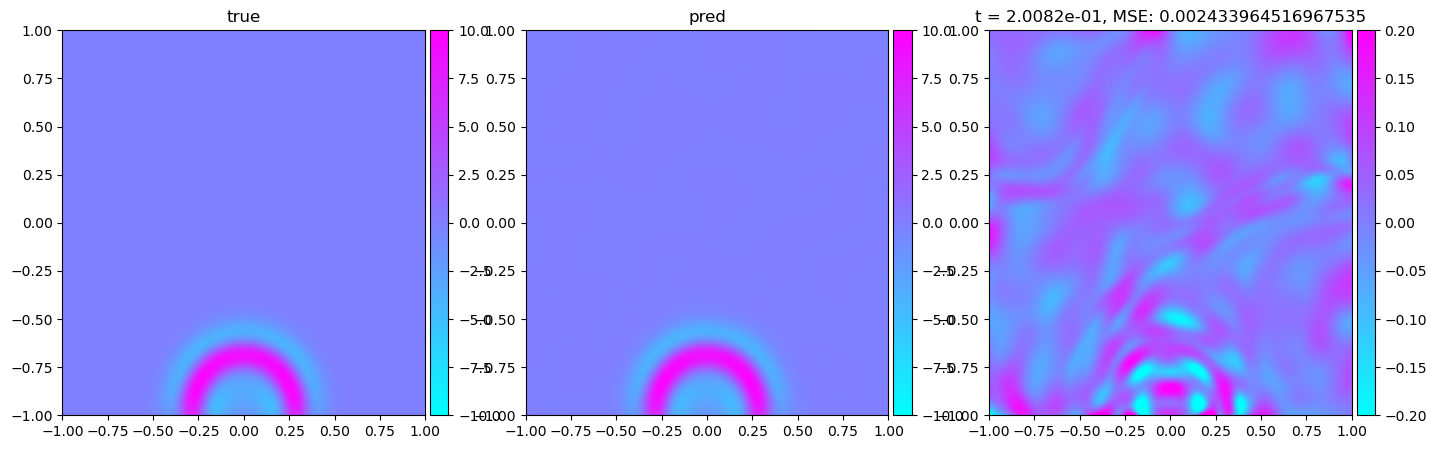

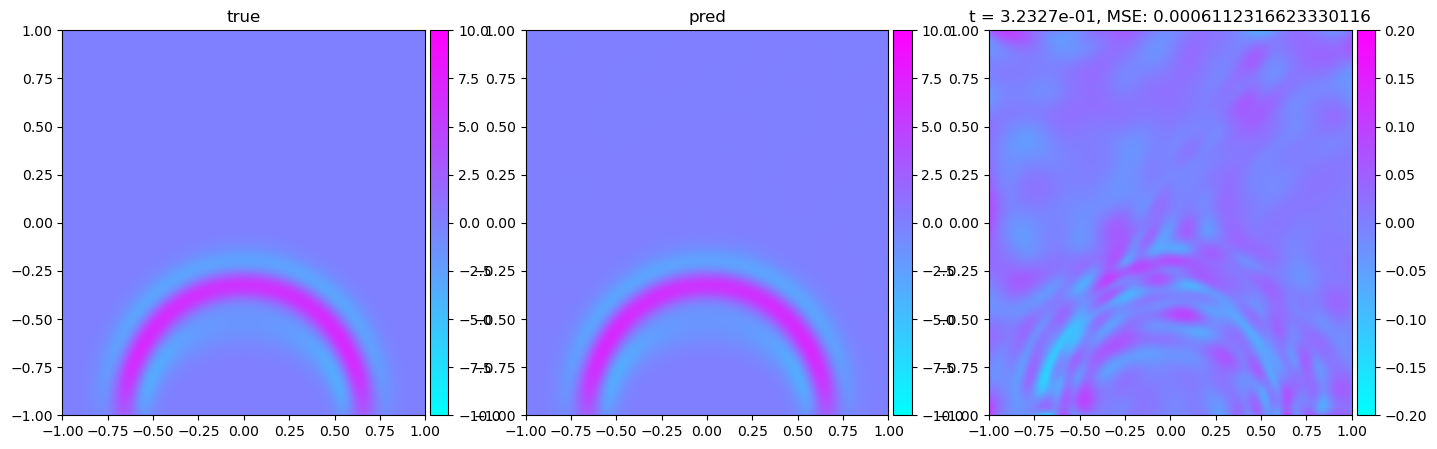

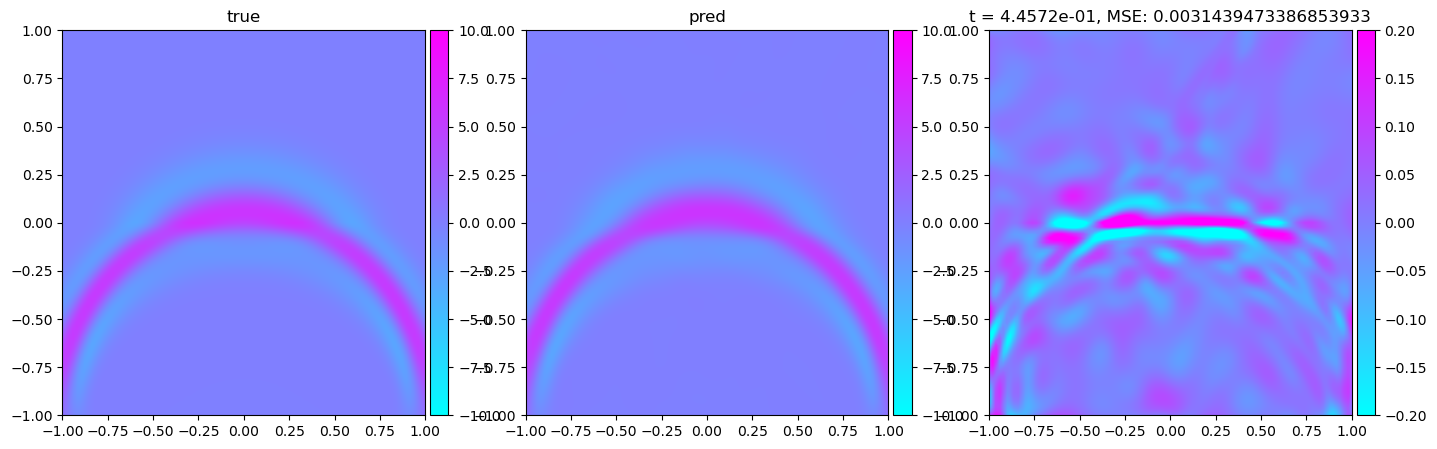

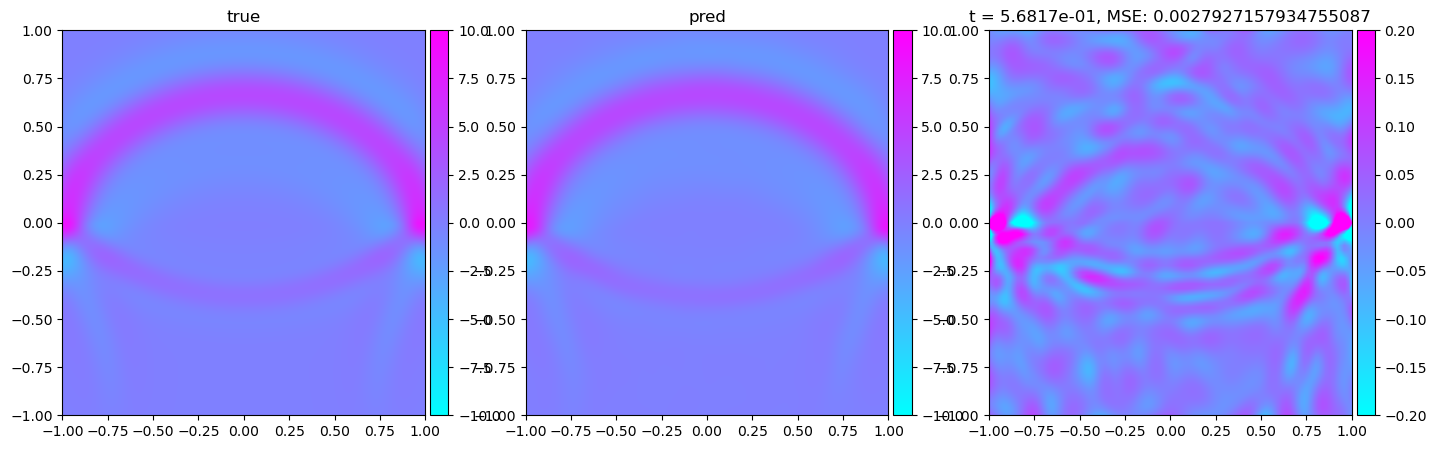

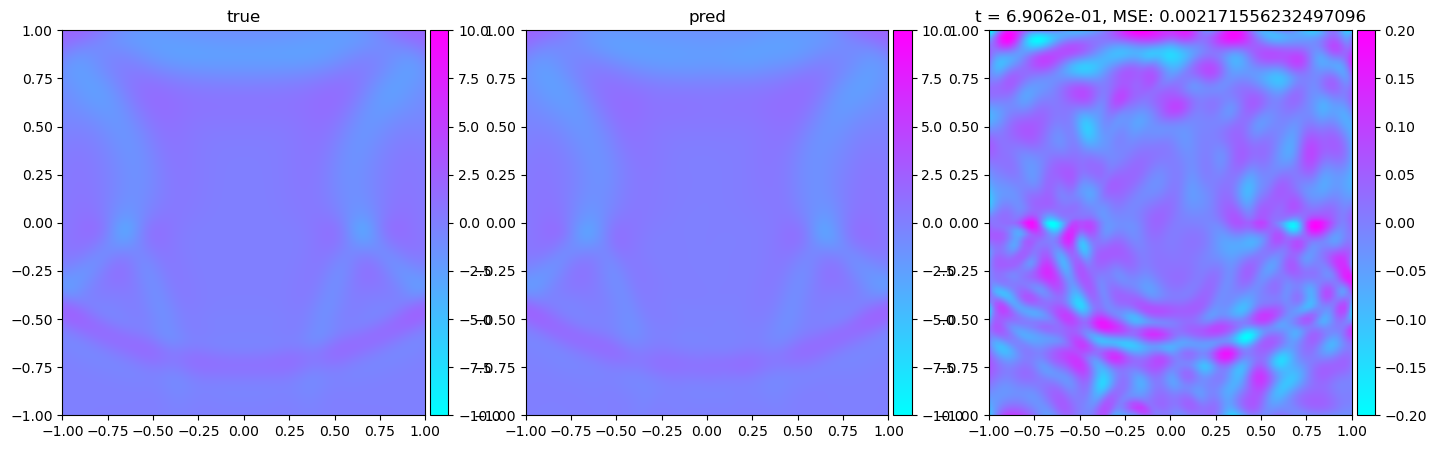

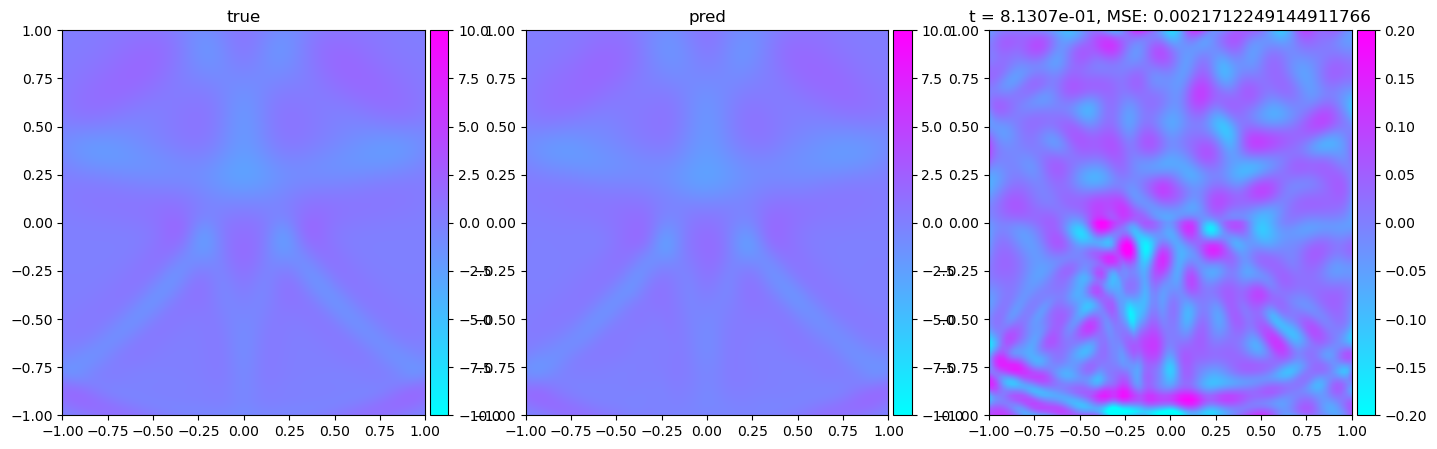

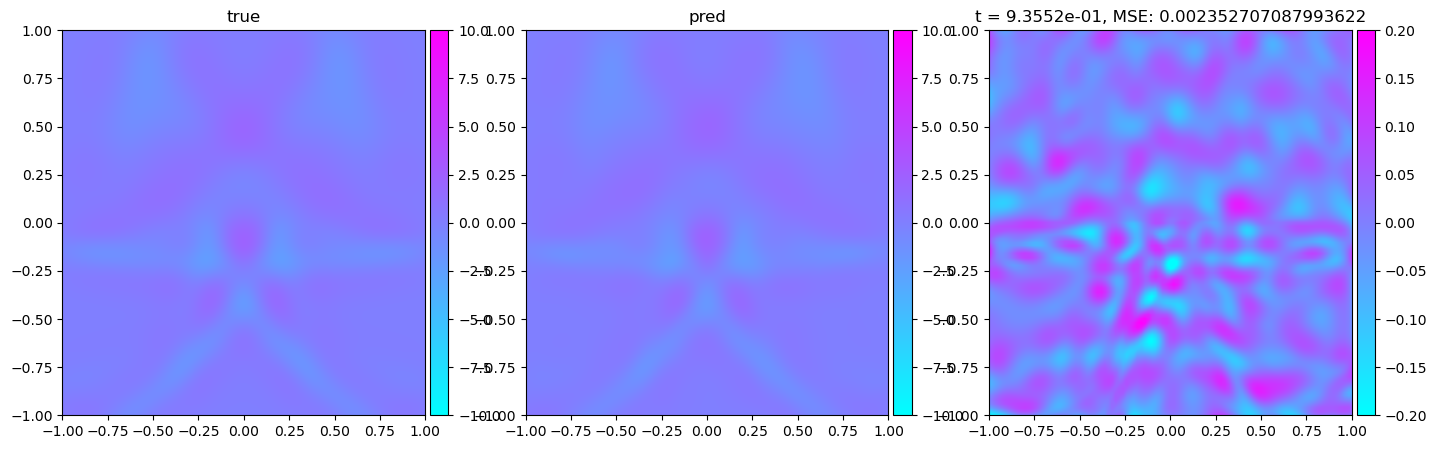

In [15]:
for i in range(0, len(t), 50):
	plot_(i)